In [1]:
from ortools.sat.python import cp_model

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import combinations, permutations
import time

In [3]:
number_tickets = 10
seating_rows = 20
seating_columns = 20
number_seats = seating_rows * seating_columns
seat_depth = 0.5
seat_depth_gap = 0.2
seat_width = 0.5
seat_width_gap = 0.2
max_group_size = 6

In [4]:
group_size_limits = {
    8 : 0,
    7 : 0,
    6 : 1,
    5 : 1,
    4 : 5,
    3 : 8,
    2 : 8,
}

In [5]:
x_seats = np.array( [ (i % seating_columns) * (seat_width + seat_width_gap) + (seat_width / 2) for i in range(number_seats) ] )

In [6]:
y_seats = np.array( [ (i // seating_columns) * (seat_depth + seat_depth_gap) + (seat_depth / 2) for i in range(number_seats) ] )

In [7]:
#ticket_size = np.random.randint(low =1, high = 10, size = number_tickets)
ticket_size = np.ones(number_tickets)

In [8]:
ticket_size

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
48%7

6

In [10]:
model = cp_model.CpModel()
model.StringParameters = "num_search_workers:8"

In [11]:
x = {}

In [12]:
def create_pairs(max_group_size):
    return combinations(range(1, max_group_size+1), 2)

In [13]:
def create_variables(max_group_size):
    for i in range(1, max_group_size+1):
        for j in range(number_seats):
            x[(i, j)] = model.NewBoolVar('x[%i,%i]' % (i, j))

In [14]:
c=0
def get_min_distance(a, b, group1, group2):
    c=0
    distances = []
    distances.append((x_seats[a] - x_seats[b])**2 + (y_seats[a] - y_seats[b])**2)
    for i in range(group1):
        for j in range(group2):
            try:
                distances.append((x_seats[a+i] - x_seats[b+j])**2 + (y_seats[a+i] - y_seats[b+j])**2)
            except:
                c += 1
                #print(a,b)
    return min(distances)

In [15]:
def create_group_size_constraints(max_group_size):
    for gp in range(1, max_group_size + 1):
        try:
            model.Add(sum( [ x[gp, j] for j in range(number_seats) ] ) <= group_size_limits[gp] )
        except:
            print("no limit for group size ", gp)

In [16]:
def create_pair_constraints(one, two):
    for a, b in permutations(range(number_seats), 2):
        if get_min_distance(a, b, one, two) < 4:
            model.Add(sum([ x[(one, a)] , x[(two, b)] ]) <= 1)
    

In [17]:
def create_individual_constraints(max_group_size):
    for i in range(1, max_group_size+1):
        for j in range(number_seats):
            if j % seating_columns >= seating_columns - i + 1:
                model.Add(x[(i, j)] == 0)

In [18]:
def create_exclusivity_constraints(max_group_size):
    for j in range(number_seats):
        terms = [ x[(i, j)] for i in range(1, max_group_size + 1) ]
        model.Add(sum(terms) <= 1)

In [19]:
def create_all_constraints(max_group_size):
    group_pairs = create_pairs(max_group_size)
    for pair in group_pairs:
        create_pair_constraints(pair[0], pair[1])
    
    group_self_pairs = [(d, d) for d in range(1, max_group_size+1)]
    for pair in group_self_pairs:
        create_pair_constraints(pair[0], pair[1])
        
    create_individual_constraints(max_group_size)
    
    create_exclusivity_constraints(max_group_size)
    
    create_group_size_constraints(max_group_size)
    

In [20]:
def main():
    # Data
    
        
    
    # Solver
    # Create the mip solver with the CBC backend.
    #solver = pywraplp.Solver.CreateSolver('assignment_mip', 'CBC')


    # Variables
    
    
    create_variables(max_group_size)
    
    # Constraints
    create_all_constraints(max_group_size)
    
    # Objective
    objective_terms = []
    for j in range(number_seats):
        for i in range(1, max_group_size):
            objective_terms.append( i * x[(i, j)] )
    
    model.Maximize(sum(objective_terms))
    
    # Solve
    solver = cp_model.CpSolver()
    solver.parameters.num_search_workers = 8
    status = solver.Solve(model)
    
    print("status is ",status)
    
    #sol_matrix
    sol_matrices = []
    sol_matrices_fmt = []
    for i in range(max_group_size):
        sol_matrices.append(np.zeros((seating_rows, seating_columns)))
        sol_matrices_fmt.append(np.zeros((seating_rows, seating_columns)))
    # Print solution.
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print('Total cost = ', solver.ObjectiveValue(), '\n')
        for k in range(len(sol_matrices)):
            for i in range(seating_columns):
                for j in range(seating_rows):
                    # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                    if solver.BooleanValue(x[(k+1, i + j * seating_columns)]):
                        #print('Worker %d assigned to task %d.  Cost = %d' %
                              #(i, j, costs[i][j]))
                            
                            sol_matrices[k][j,i] = 1 * (k+1)
                            for m in range(0,k+1):
                                sol_matrices_fmt[k][j , i + m] = 1 * (k+1)
                    
        return(sol_matrices, sol_matrices_fmt)
    else:
        return status


In [21]:
t1 = time.time()
soln = main()
t2 = time.time()
t2-t1

no limit for group size  1
status is  4
Total cost =  80.0 



80.48900175094604

In [22]:
sum(soln[0])

array([[2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 3., 0., 0.,
        0., 0., 2., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0.,
        4., 0., 0., 0.],
       [1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
        0., 3., 0., 0.],
       [1., 0., 0., 1., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 2., 0.],
       [4., 0., 0., 0., 0., 0.

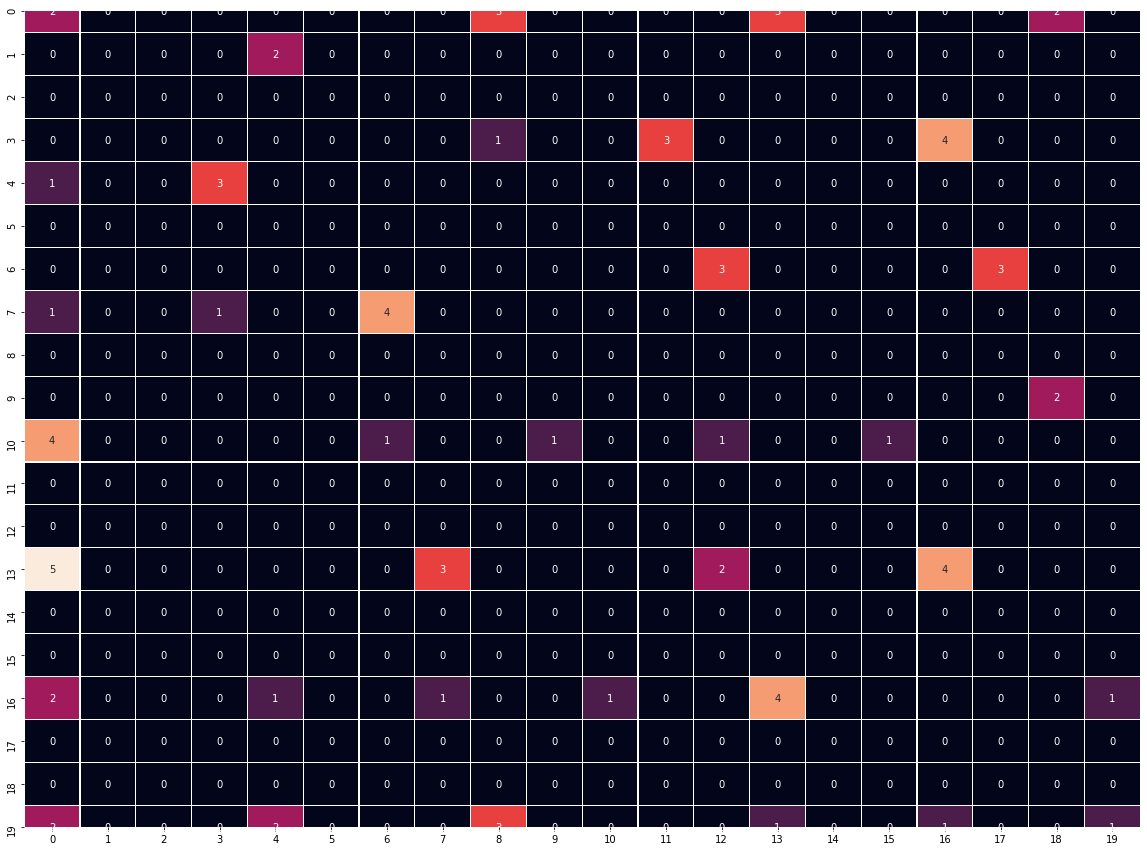

In [23]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(sum(soln[0]), linecolor = 'white', linewidths = 0.1, annot = True, ax = ax, cbar =False)

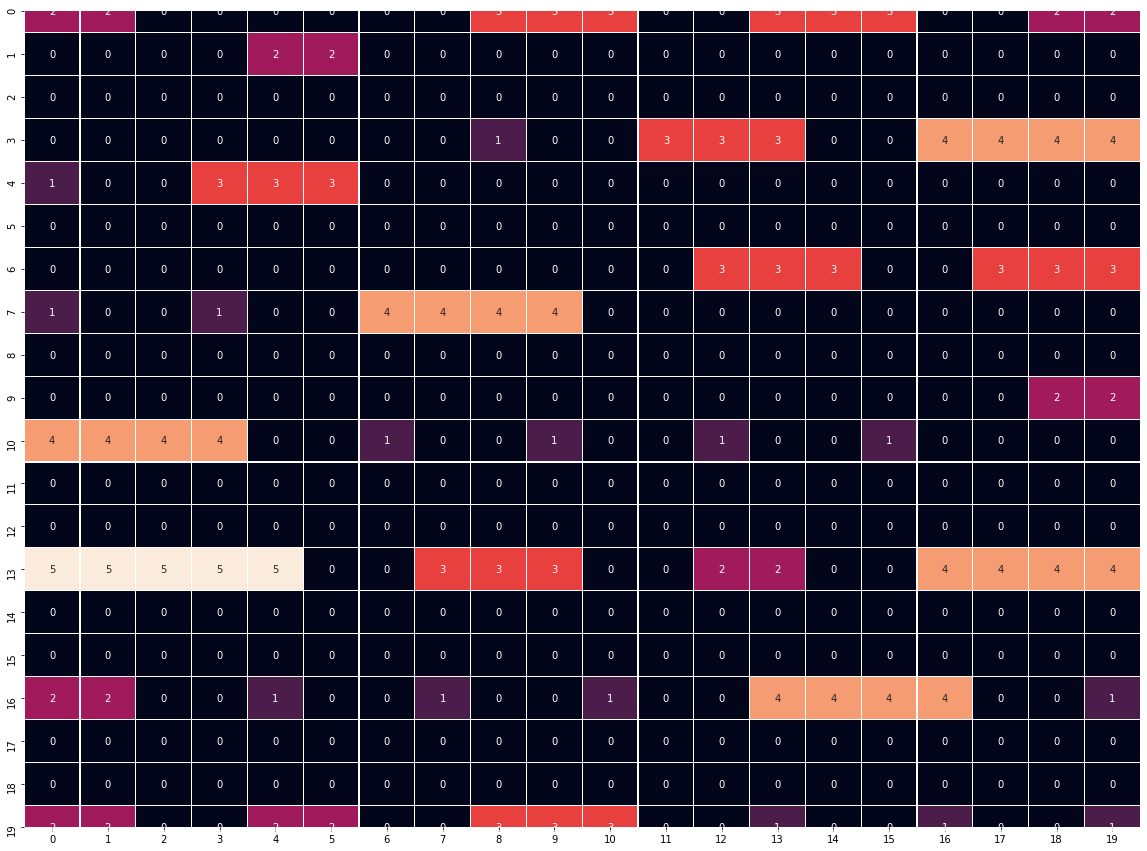

In [24]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(sum(soln[1]), linecolor = 'white', linewidths = 0.1, annot = True, ax = ax, cbar =False)